This notebook supports the equations that govern contaminant uptake and impacts on the biology within the Salish Sea Atlantis model. It shows the 1-day output of simulations after injecting PAH components of oil into the water column, to observe biological uptake, as well as non-lethal and lethal impacts relative to a control simulation with no contaminants injected.

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

In [2]:
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
from pathlib import Path
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [3]:
control_name = 'highres_no_closure'
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [4]:
time = np.ma.filled(control.variables['t'], np.nan)

In [5]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/')
scenario_paths = sorted([p for p in scenario_root.glob('highres_2boxes_closed_90/outputSalishSea.nc')])
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]
for path in scenario_paths:
    print(path.parent.stem)

highres_2boxes_closed_90


In [6]:
scenario_labels = []
for path in scenario_paths:
    scenario_labels.append(path.parent.stem)

In [7]:
def compare_scenario_pah(species, pah, boxes=groups.salish_sea):
    fig, ax = plt.subplots(figsize = (14,3))
    names = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        names.append(path.parent.stem)
        contam_tbl = np.ma.filled(scenario.variables[species+'_' + pah][:,boxes,:], np.nan)
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,boxes,:], np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)
        ax.plot(duration, contam_mass_t/1e6)
    ax.legend(names)
    ax.set_ylabel(species + ' PAH (kg)')
    ax.set_title(pah, fontsize = 12);

In [8]:
def print_max_pah_conc(species, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        for pah in groups.pahs:
            contam_tbl = np.ma.filled(scenario.variables[species +'_'+ pah], np.nan)
            contam_tb = contam_tbl.sum(axis=2)
            contam_t = contam_tb.sum(axis=1)
            max_contam_mass = contam_t.max()/1e6
            print(path.parent.stem, species, pah, max_contam_mass)

In [9]:
def group_mass(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tbl = np.ma.filled(scenario.variables[variable], np.nan)
            volume_tbl = np.ma.filled(scenario.volume, np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_mass_tbl = contam_tbl * volume_tbl
            contam_mass_tb = contam_mass_tbl.sum(axis=2)
            contam_mass_t = contam_mass_tb.sum(axis=1)
            ax.plot(time, contam_mass_t/1e6) 
            np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+str(variable)+".csv", contam_mass_t, delimiter = ",")
        ax.legend(group,  loc='best')
        ax.set_ylabel('mass (Kg)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

In [10]:
def group_conc(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tbl = np.ma.filled(scenario.variables[variable], np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_tb = contam_tbl.sum(axis=2)
            contam_t = contam_tb.sum(axis=1)
            ax.plot(time, contam_t) #zoom into recruitement of Chinook [40:60]
            #np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+str(variable)+".csv", contam_t, delimiter = ",")
        ax.legend(group,  loc='best')
        ax.set_ylabel('Concentration (mg/m$^3$)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

In [11]:
def group_conc_benthic(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tb = np.ma.filled(scenario.variables[variable], np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_t = contam_tb.sum(axis=1)
            np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+str(variable)+".csv", contam_t, delimiter = ",")
            ax.plot(time, contam_t) #zoom into recruitement of Chinook [40:60]
        ax.legend(group,  loc='best')
        ax.set_ylabel('Concentration (mg/m$^2$)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

### Water column contaminants

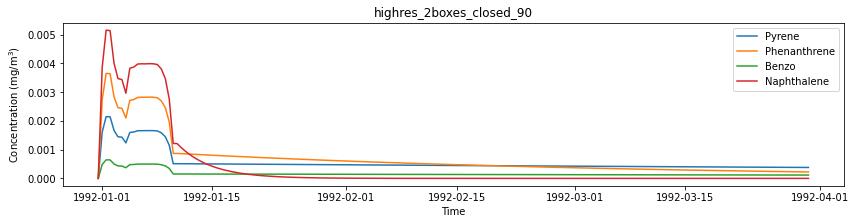

In [12]:
group_conc(groups.pahs, scenario_datasets, scenario_paths)


In [14]:
start = 0
end = 180
event_start = time[0]

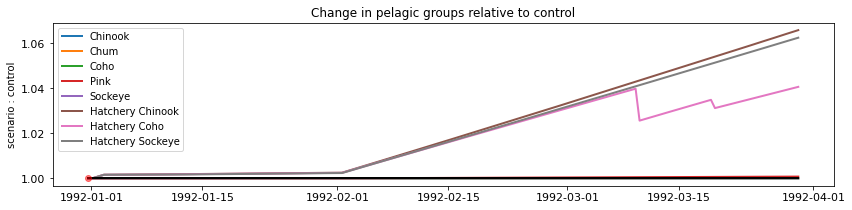

In [15]:
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.salmon, scenario, control, time, start, end, groups.salish_sea, event_start)

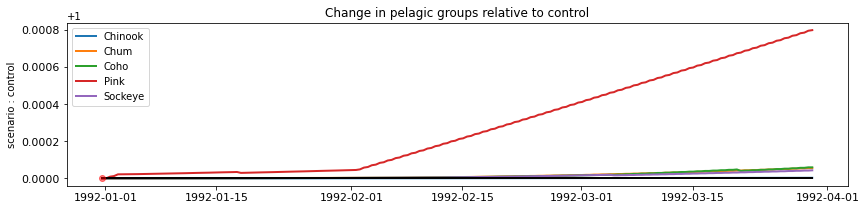

In [16]:
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.wild_salmon, scenario, control, time, start, end, groups.salish_sea, event_start)

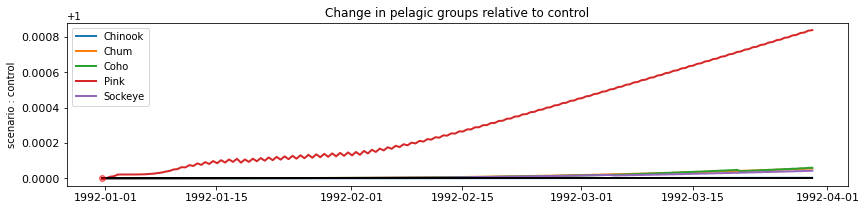

In [17]:
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.wild_salmon, scenario, control, time, start, end, groups.haro_boundary, event_start)

Calculate mean change in biomass at the end of the simulation

In [ ]:
boxes = groups.salish_sea
mean_start = end-11
biomass_change = []
for scenario in scenario_datasets:
    for group in groups.plankton:
        scenario_tbl = np.ma.filled(scenario.variables[groups.plankton[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        control_tbl = np.ma.filled(control.variables[groups.plankton[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        scenario_tb = scenario_tbl.mean(axis=2)
        control_tb = control_tbl.mean(axis=2)
        scenario_t = scenario_tb.mean(axis=1)
        control_t = control_tb.mean(axis=1)
        biomass_change.append((scenario_t.mean()/control_t.mean()-1)*100)
salishsea_change = biomass_change
salishsea_change

In [ ]:
label_size = 11
font_size = 12
line_width = 2
indicators = groups.plankton
num_vars = len(indicators)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
salishsea_change += salishsea_change[:1]
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.plot(angles, salishsea_change, linewidth=line_width, label='Mortality effect of spill on entire Salish Sea')
ax.plot(angles, np.zeros(num_vars+1), 'k--',linewidth=line_width, label='Control with no contaminants')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180 / num_vars)
ax.set_ylim(-25, 0)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(indicators)
ax.tick_params(axis='x', labelsize=font_size)
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size);

#### Higher trophic levels

- Biomass = mgN/m3 (XXX_N)
- Growth = structural N / individual of a oldest cohort (XXX_StructN/XXX_Nums)
- Reproduction = numbers of cohort 1 (XX1_Nums)

In [31]:
# Salish Sea Atlantis Shapefile
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]

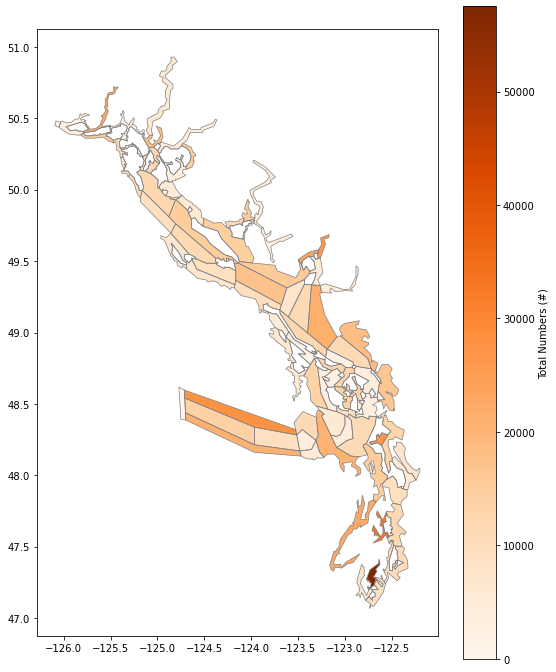

In [32]:
for scenario, path in zip(scenario_datasets, scenario_paths):
    numbers_tbl = scenario.variables['Pink_salmon3_Nums'][0,:,:] # Initial Pink Salmon Numbers
    numbers_tb = numbers_tbl.sum(axis=1)
    #numbers_b = numbers_tb.sum(axis=0)
    _cmap = cm.Oranges
    land_df = data_df.loc[land_boxes]
        
    data_df['sum_numbers'] = numbers_tb
    data_df.loc[land_boxes, 'sum_numbers'] = 0
        
    ax = data_df.plot(figsize=(9, 12), column = 'sum_numbers', cmap=_cmap,
        legend=True, legend_kwds={'label': "Total Numbers (#)"
            },)
    land_df.plot(ax=ax, color='white')
    data_df.boundary.plot(ax=ax, color="grey", linewidths=0.7)

In [27]:
def compare_scenario_nums(variable, box):
    fig, ax = plt.subplots(figsize = (14,3))
    names = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        names.append(path.parent.stem)
        nums_tl = scenario.variables[variable+'_Nums'][:,box]
        nums_t = nums_tl.sum(axis=1)
        time = scenario.variables['t']
        ax.plot(time, nums_t)
    ax.legend(names)
    ax.set_ylabel(variable + ' Numbers (#)')
    #ax.set_title(pah, fontsize = 12);

In [18]:
boxes = groups.haro_boundary
mean_start = end-11

In [22]:

def plot_radar_contam_biomass_growth_reprod(bio_group, boxes, mean_start, end):
    label_size = 11
    font_size = 12
    line_width = 2
    for scenario in scenario_datasets:
        biomass_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
            scenario_tb = scenario_tbl.mean(axis=2)
            control_tb = control_tbl.mean(axis=2)
            scenario_t = scenario_tb.mean(axis=1)
            control_t = control_tb.mean(axis=1)
            biomass_change.append((scenario_t.mean()/control_t.mean()-1)*100)
        biomass_change += biomass_change[:1]

        growth_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_StructN'][mean_start:end,boxes,0:6], np.nan)
            scenario_nums_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_Nums'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_StructN'][mean_start:end,boxes,0:6], np.nan)
            control_nums_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_Nums'][mean_start:end,boxes,0:6], np.nan)
            scenario_growth_tbl = scenario_tbl * (1/(scenario_nums_tbl+(scenario_nums_tbl==0)))
            control_growth_tbl = control_tbl * (1/(control_nums_tbl+(control_nums_tbl==0)))
            scenario_growth_tb = scenario_growth_tbl.mean(axis=2)
            control_growth_tb = control_growth_tbl.mean(axis=2)
            scenario_growth_t = scenario_growth_tb.mean(axis=1)
            control_growth_t = control_growth_tb.mean(axis=1)
            growth_change.append((scenario_growth_t.mean()/control_growth_t.mean()-1)*100)
        growth_change += growth_change[:1]

        reprod_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'1_Nums'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+'1_Nums'][mean_start:end,boxes,0:6], np.nan)
            scenario_tb = scenario_tbl.mean(axis=2)
            control_tb = control_tbl.mean(axis=2)
            scenario_t = scenario_tb.mean(axis=1)
            control_t = control_tb.mean(axis=1)
            reprod_change.append((scenario_t.mean()/control_t.mean()-1)*100)
        reprod_change += reprod_change[:1]

        data_values = {'Contaminant effect on biomass':biomass_change,'Contaminant effect on growth':growth_change,'Contaminant effect on reproduction':reprod_change}
        num_vars = len(bio_group)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
        for item in data_values:
            ax.plot(angles, data_values[item], linewidth=line_width, label=item)
        ax.plot(angles, np.zeros(num_vars+1), 'k--',linewidth=line_width, label='Control, no contaminants')
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(180 / num_vars)
        ax.set_ylim(-5, 0)
        ax.tick_params(axis='y', labelsize=font_size)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(bio_group)
        ax.tick_params(axis='x', labelsize=font_size)
        for label, angle in zip(ax.get_xticklabels(), angles):
            if angle in (0, np.pi):
                label.set_horizontalalignment('center')
            elif 0 < angle < np.pi:
                label.set_horizontalalignment('left')
            else:
                label.set_horizontalalignment('right')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size);

In [29]:

def plot_radar_closure_biomass_growth_reprod(bio_group, boxes, mean_start, end):
    label_size = 11
    font_size = 12
    line_width = 2
    for scenario in scenario_datasets:
        biomass_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
            scenario_tb = scenario_tbl.mean(axis=2)
            control_tb = control_tbl.mean(axis=2)
            scenario_t = scenario_tb.mean(axis=1)
            control_t = control_tb.mean(axis=1)
            biomass_change.append((scenario_t.mean()/control_t.mean()-1)*100)
        biomass_change += biomass_change[:1]

        growth_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_StructN'][mean_start:end,boxes,0:6], np.nan)
            scenario_nums_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_Nums'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_StructN'][mean_start:end,boxes,0:6], np.nan)
            control_nums_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_Nums'][mean_start:end,boxes,0:6], np.nan)
            scenario_growth_tbl = scenario_tbl * (1/(scenario_nums_tbl+(scenario_nums_tbl==0)))
            control_growth_tbl = control_tbl * (1/(control_nums_tbl+(control_nums_tbl==0)))
            scenario_growth_tb = scenario_growth_tbl.mean(axis=2)
            control_growth_tb = control_growth_tbl.mean(axis=2)
            scenario_growth_t = scenario_growth_tb.mean(axis=1)
            control_growth_t = control_growth_tb.mean(axis=1)
            growth_change.append((scenario_growth_t.mean()/control_growth_t.mean()-1)*100)
        growth_change += growth_change[:1]

        reprod_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'1_Nums'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+'1_Nums'][mean_start:end,boxes,0:6], np.nan)
            scenario_tb = scenario_tbl.mean(axis=2)
            control_tb = control_tbl.mean(axis=2)
            scenario_t = scenario_tb.mean(axis=1)
            control_t = control_tb.mean(axis=1)
            reprod_change.append((scenario_t.mean()/control_t.mean()-1)*100)
        reprod_change += reprod_change[:1]

        data_values = {'ContamClosure effect on biomass':biomass_change,'ContamClosure effect on growth':growth_change,'ContamClosure effect on reproduction':reprod_change}
        num_vars = len(bio_group)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
        for item in data_values:
            ax.plot(angles, data_values[item], linewidth=line_width, label=item)
        ax.plot(angles, np.zeros(num_vars+1), 'k--',linewidth=line_width, label='Control, no closures')
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(180 / num_vars)
        ax.set_ylim(-5, 0)
        ax.tick_params(axis='y', labelsize=font_size)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(bio_group)
        ax.tick_params(axis='x', labelsize=font_size)
        for label, angle in zip(ax.get_xticklabels(), angles):
            if angle in (0, np.pi):
                label.set_horizontalalignment('center')
            elif 0 < angle < np.pi:
                label.set_horizontalalignment('left')
            else:
                label.set_horizontalalignment('right')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size);

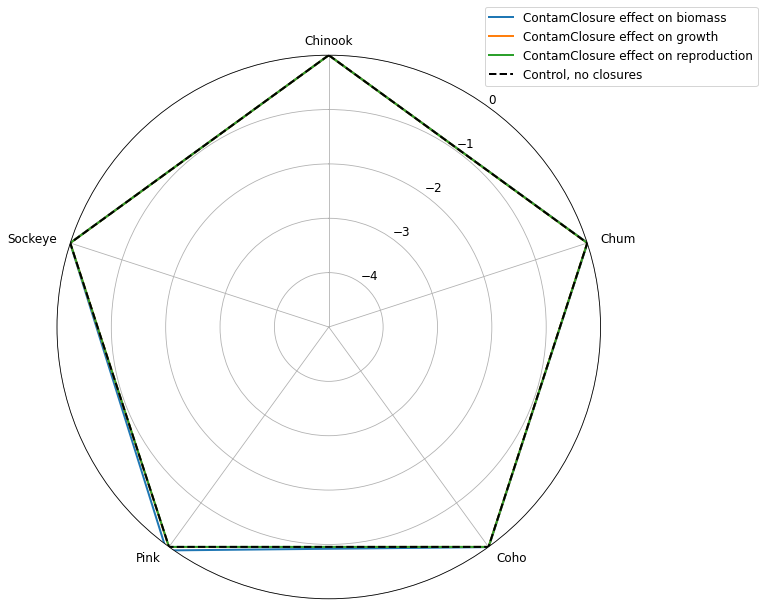

In [30]:
plot_radar_closure_biomass_growth_reprod(groups.wild_salmon, boxes, mean_start, end)

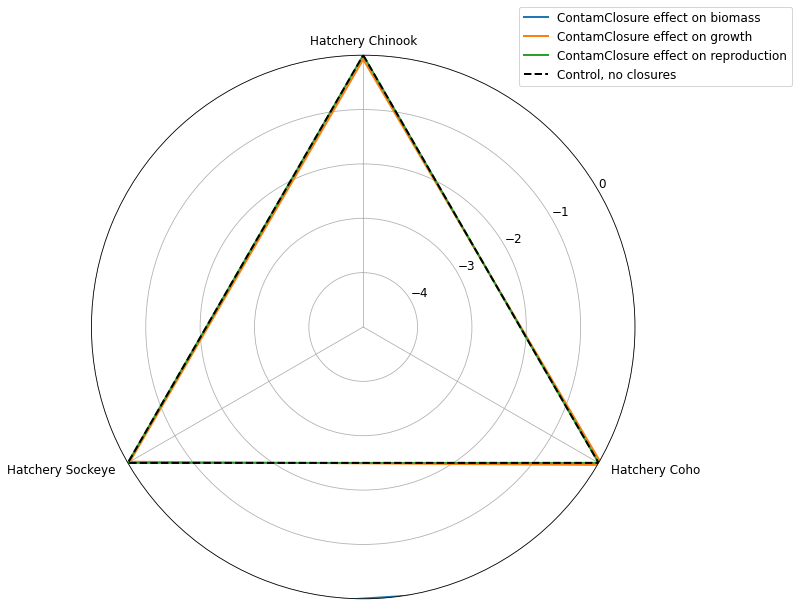

In [24]:
plot_radar_closure_biomass_growth_reprod(groups.hatchery_salmon, boxes, mean_start, end)